In [2]:
from deepCR import deepCR
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import cm
import h5py
import numpy as np
import os

# DeepCR Quickstart

In [3]:
data_dir = os.environ.get('DEEPCR_DIR')
!ls $data_dir

jdba2sooq_flc.fits test_set


In [4]:
image1 = fits.getdata(data_dir + 'demo/jdba2sooq_flc.fits')
print(image1.shape)
image = image1[:256,:256]
print(image.shape)

(2048, 4096)
(256, 256)


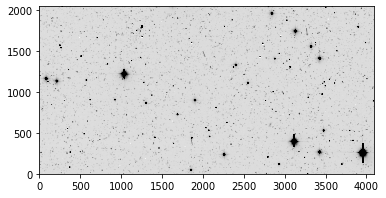

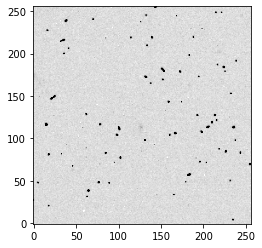

In [5]:
plt.imshow(image1, cmap = 'gray_r', vmin = 0, vmax = 250, origin='lower')
plt.show()
plt.imshow(image, cmap = 'gray_r', vmin = 0, vmax = 250, origin= 'lower')
plt.show()
image2 = image1[500-256:500,3000:3256]

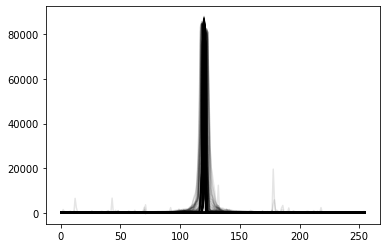

In [6]:
for row in image2:
    plt.plot(np.arange(len(row)), row, alpha = 0.1, c = 'k')

In [7]:
mdl = deepCR(mask="ACS-WFC-F606W-2-32",
             inpaint="ACS-WFC-F606W-2-32",
             device="CPU")

In [8]:
mask, cleaned_image = mdl.clean(image, threshold = 0.5)
mask2, cleaned_image2 = mdl.clean(image2, threshold = 0.5)
mask3, cleaned_image3 = mdl.clean(image2, threshold = 1e-8)
# mask = mdl.clean(image, threshold = 0.5, inpaint = False)
# prob_mask = mdl.clean(image, binary=False)
# mask, cleaned_image = mdl.clean(image, threshold = 0.5, n_jobs=-1)
# mask, cleaned_image = mdl.clean(image, threshold = 0.5, inpaint = False, segment = True)

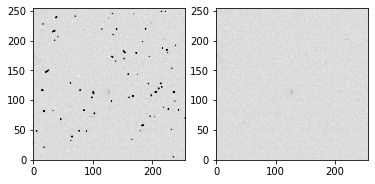

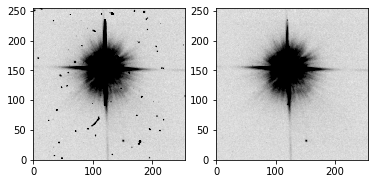

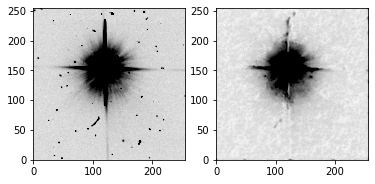

In [9]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(image, cmap = 'gray_r', vmin = 0, vmax = 250, origin = 'lower')
axs[1].imshow(cleaned_image, cmap = 'gray_r', vmin = 0, vmax = 250, origin = 'lower')
fig, axs = plt.subplots(1,2)
axs[0].imshow(image2, cmap = 'gray_r', vmin = 0, vmax = 250, origin = 'lower')
axs[1].imshow(cleaned_image2, cmap = 'gray_r', vmin = 0, vmax = 250, origin = 'lower')
fig, axs = plt.subplots(1,2)
axs[0].imshow(image2, cmap = 'gray_r', vmin = 0, vmax = 250, origin = 'lower')
axs[1].imshow(cleaned_image3, cmap = 'gray_r', vmin = 0, vmax = 250, origin = 'lower')

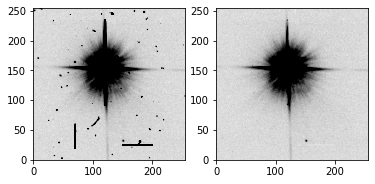

In [11]:
custom = image2.copy()
custom[20:60,70]= 60000
custom[25,150:200] = 50000
mask, custom_clean = mdl.clean(custom, threshold = 0.5)
fig, axs = plt.subplots(1,2)
axs[0].imshow(custom, vmin = 0, vmax = 250, cmap = 'gray_r', origin = 'lower')
axs[1].imshow(custom_clean, vmin = 0, vmax = 250, cmap = 'gray_r', origin = 'lower')

# Training

In [133]:
import glob as glob
import shutil
from astropy.io import ascii

from astropy.table import Table
from astropy.visualization import ZScaleInterval
from astroquery.mast import Observations
from ccdproc import ImageFileCollection
from drizzlepac import tweakreg
from drizzlepac import astrodrizzle
from IPython.display import Image
import matplotlib.pyplot as plt

%matplotlib inline

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


In [162]:
trTable = Observations.query_criteria(obstype='all',
                                      obs_collection='HST',
                                      obs_id = ['j97001010','j97005010',
                                               'j97007010','jbit11010',
                                               'j9l907010','j9l908010',
                                               'j8z003010','j8z004010',
                                               'j8z006010','j8z008010',
                                               'j9el32020'])
tsTable = Observations.query_criteria(obstype='all',
                                      obs_collection='HST',
                                      obs_id = ['jcoz44010','j9l906010',
                                               'j9l909010','j90o28050'])

In [ ]:
tr_product = Observations.get_product_list(trTable)
ts_product = Observations.get_product_list(tsTable)

Observations.download_products(tr_product,
                              download_dir = '/Users/jameskwon/Documents/Research/Data/deepcr/training_flc_set',
                              mrp_only = False,
                              productSubGroupDescription='FLC')
Observations.download_products(ts_product,
                              download_dir = '/Users/jameskwon/Documents/Research/Data/deepcr/test_flc_set',
                              mrp_only = False,
                              productSubGroupDescription='FLC')